In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(style='darkgrid')
colors = sns.color_palette('bright')

plt.rc('axes', titlesize=20) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=16) # fontsize of the tick labels
plt.rc('ytick', labelsize=16) # fontsize of the tick labels
plt.rc('legend', fontsize=18) # legend fontsize
plt.rc('font', size=13) # controls default text sizes

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Daily Female Birth DF

In [2]:
daily_birth_df = pd.read_csv('data/daily-total-female-births.csv')

In [3]:
daily_birth_df.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [4]:
daily_birth_df.tail()

,Date,Births
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55
364,1959-12-31,50


In [5]:
daily_birth_df.shape

(365, 2)

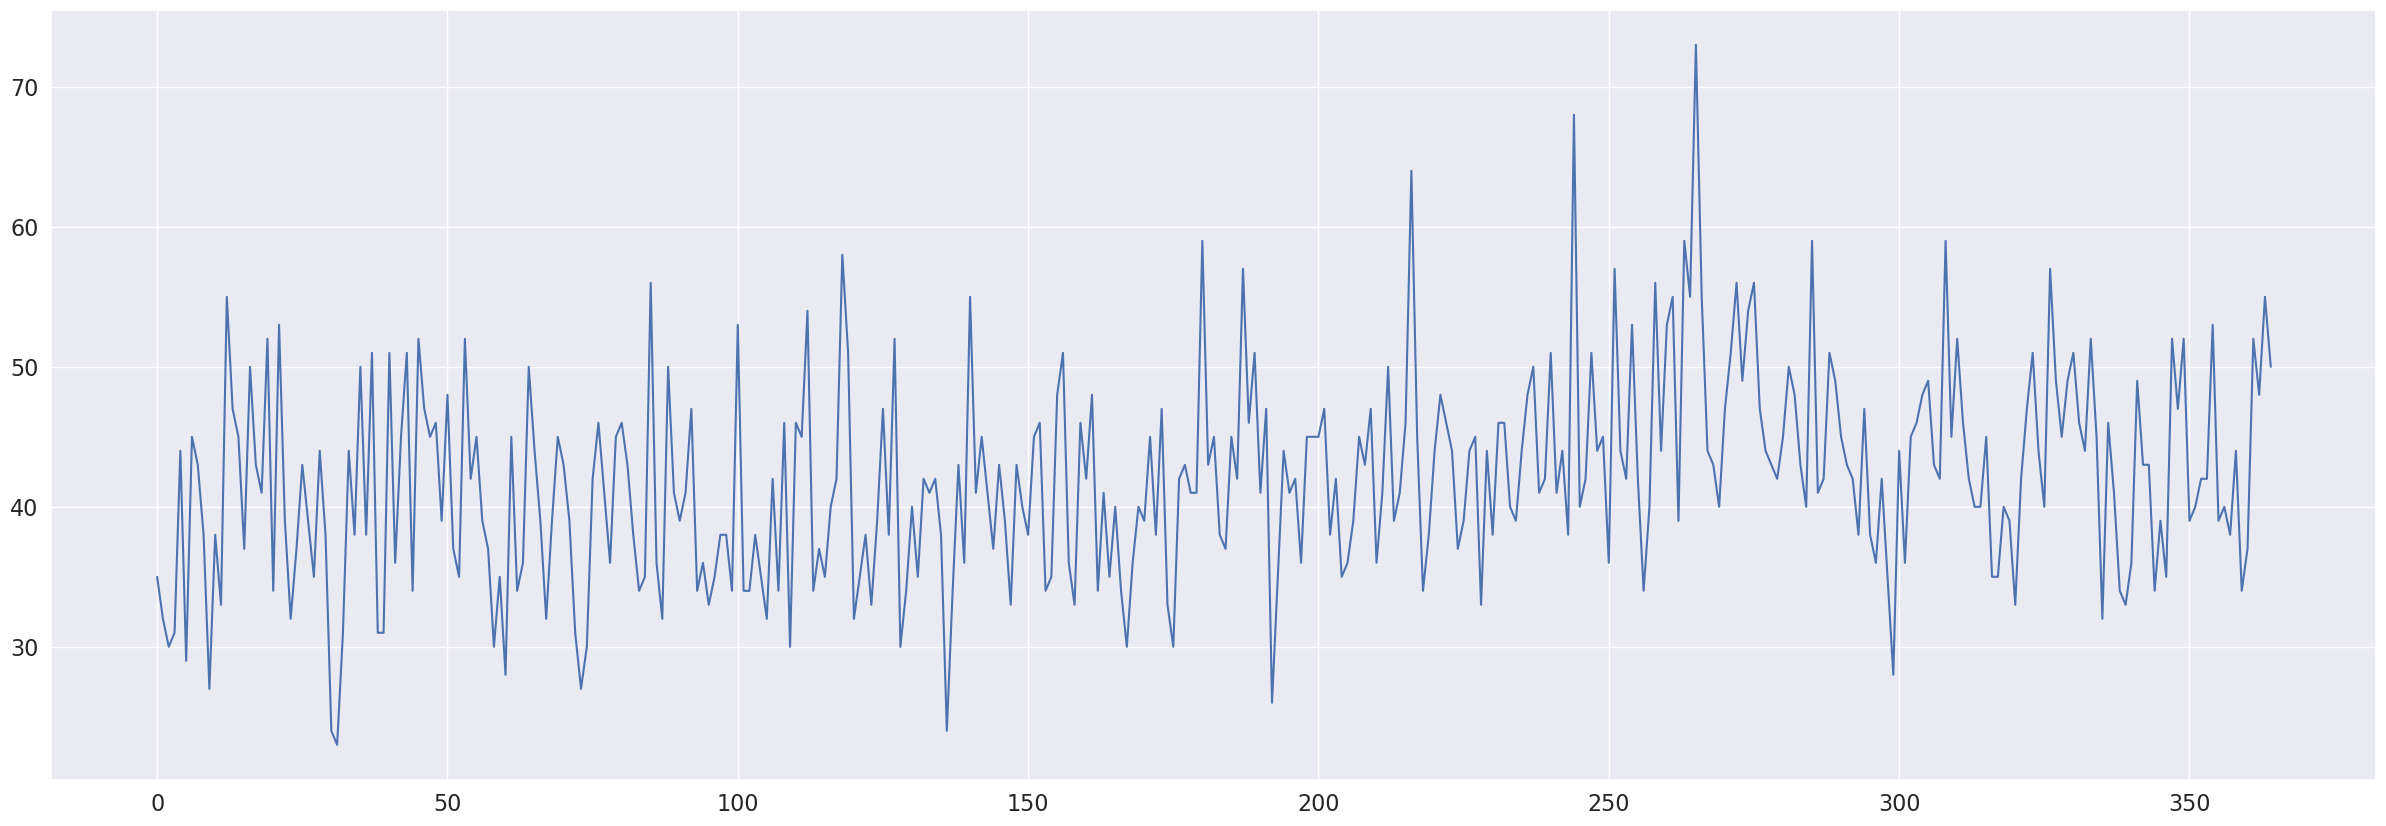

In [6]:
plt.rcParams['figure.figsize']=[30,10]

plt.plot(daily_birth_df['Births'])

In [7]:
daily_birth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


### Split Data Into Train and Test

In [8]:
daily_birth_df_values = daily_birth_df['Births'].values
train, test = daily_birth_df_values[0:-165], daily_birth_df_values[-165:]

### LSTM Data Preparation

### Transform Time Series to Scale

In [11]:
from sklearn.preprocessing import MinMaxScaler

X = daily_birth_df['Births'].values
X = X.reshape(len(X), 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_daily_birth = scaler.transform(X)

In [12]:
scaled_daily_birth = np.float32(scaled_daily_birth)

### LSTM Model Development

In [13]:
import torch

from torch import nn, optim

import torch.nn.functional as F

plt.rcParams.update({'font.size': 15})

torch.manual_seed(RANDOM_SEED)

### Creating Dataset

In [14]:
train_scaled, test_scaled = scaled_daily_birth[0:-165], scaled_daily_birth[-165:]

In [15]:
print('Train shape: {0}, test shape: {1}'.format(train_scaled.shape,test_scaled.shape))

Train shape: (200, 1), test shape: (165, 1)


### Baseline

RMSE: 0.349


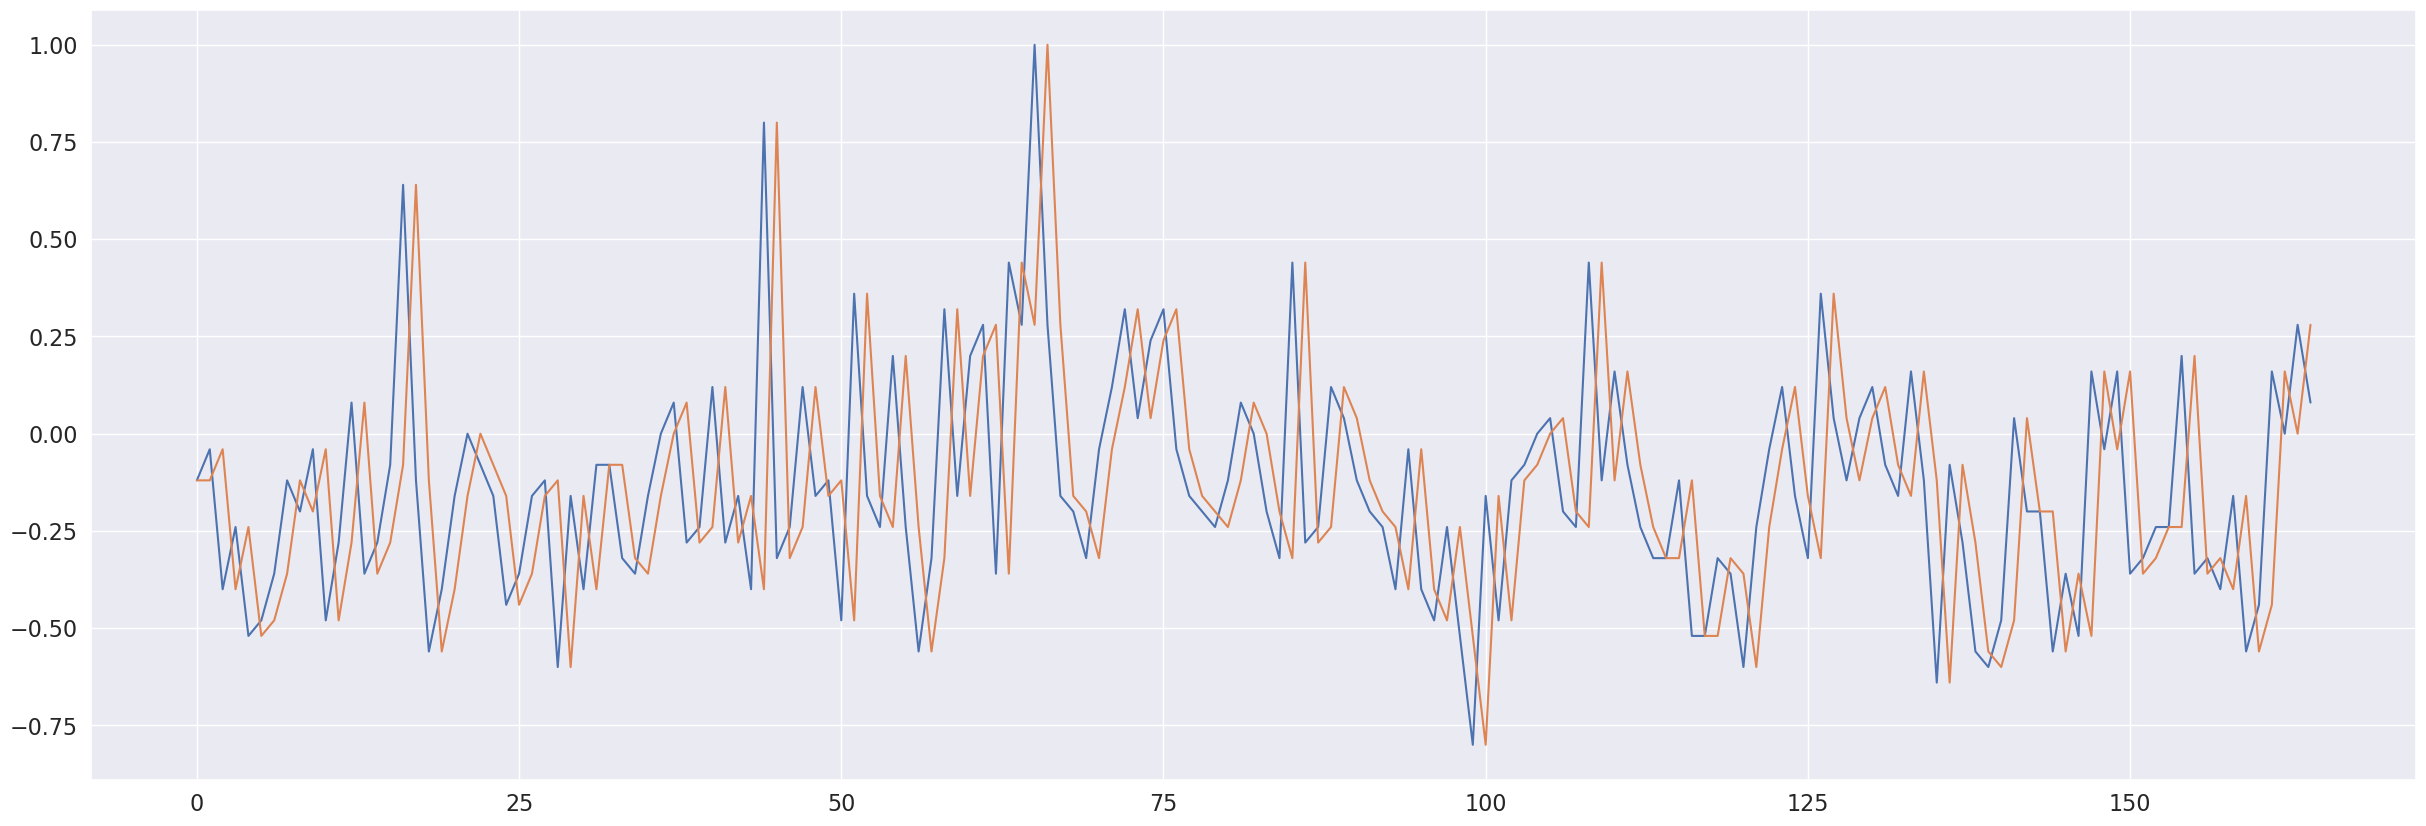

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# walk-forward validation
history = [x for x in train_scaled]
predictions = list()

for i in range(len(test_scaled)):
  # make prediction
  predictions.append(history[-1])
  # observation
  history.append(test_scaled[i])

# report performance
rmse = sqrt(mean_squared_error(test_scaled, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
pyplot.plot(test_scaled)
pyplot.plot(predictions)
pyplot.show()

### Creating Dataset

In [17]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [18]:
lookback = 5
X_train, y_train = create_dataset(train_scaled, lookback=lookback)
X_test, y_test = create_dataset(test_scaled, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([195, 5, 1]) torch.Size([195, 5, 1])
torch.Size([160, 5, 1]) torch.Size([160, 5, 1])


### LSTM

In [19]:
class DailyBirthModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Training

In [20]:
import torch.utils.data as data

model = DailyBirthModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [21]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.2894, test RMSE 0.3234
Epoch 100: train RMSE 0.2766, test RMSE 0.3222
Epoch 200: train RMSE 0.2652, test RMSE 0.3394
Epoch 300: train RMSE 0.2599, test RMSE 0.3427
Epoch 400: train RMSE 0.2497, test RMSE 0.3389
Epoch 500: train RMSE 0.2399, test RMSE 0.3384
Epoch 600: train RMSE 0.2273, test RMSE 0.3697
Epoch 700: train RMSE 0.2185, test RMSE 0.3854
Epoch 800: train RMSE 0.2130, test RMSE 0.3906
Epoch 900: train RMSE 0.2092, test RMSE 0.4017
Epoch 1000: train RMSE 0.2007, test RMSE 0.4060
Epoch 1100: train RMSE 0.1959, test RMSE 0.4172
Epoch 1200: train RMSE 0.1944, test RMSE 0.4311
Epoch 1300: train RMSE 0.1909, test RMSE 0.4267
Epoch 1400: train RMSE 0.1882, test RMSE 0.4383
Epoch 1500: train RMSE 0.1854, test RMSE 0.4384
Epoch 1600: train RMSE 0.1847, test RMSE 0.4476
Epoch 1700: train RMSE 0.1831, test RMSE 0.4534
Epoch 1800: train RMSE 0.1802, test RMSE 0.4612
Epoch 1900: train RMSE 0.1804, test RMSE 0.4679


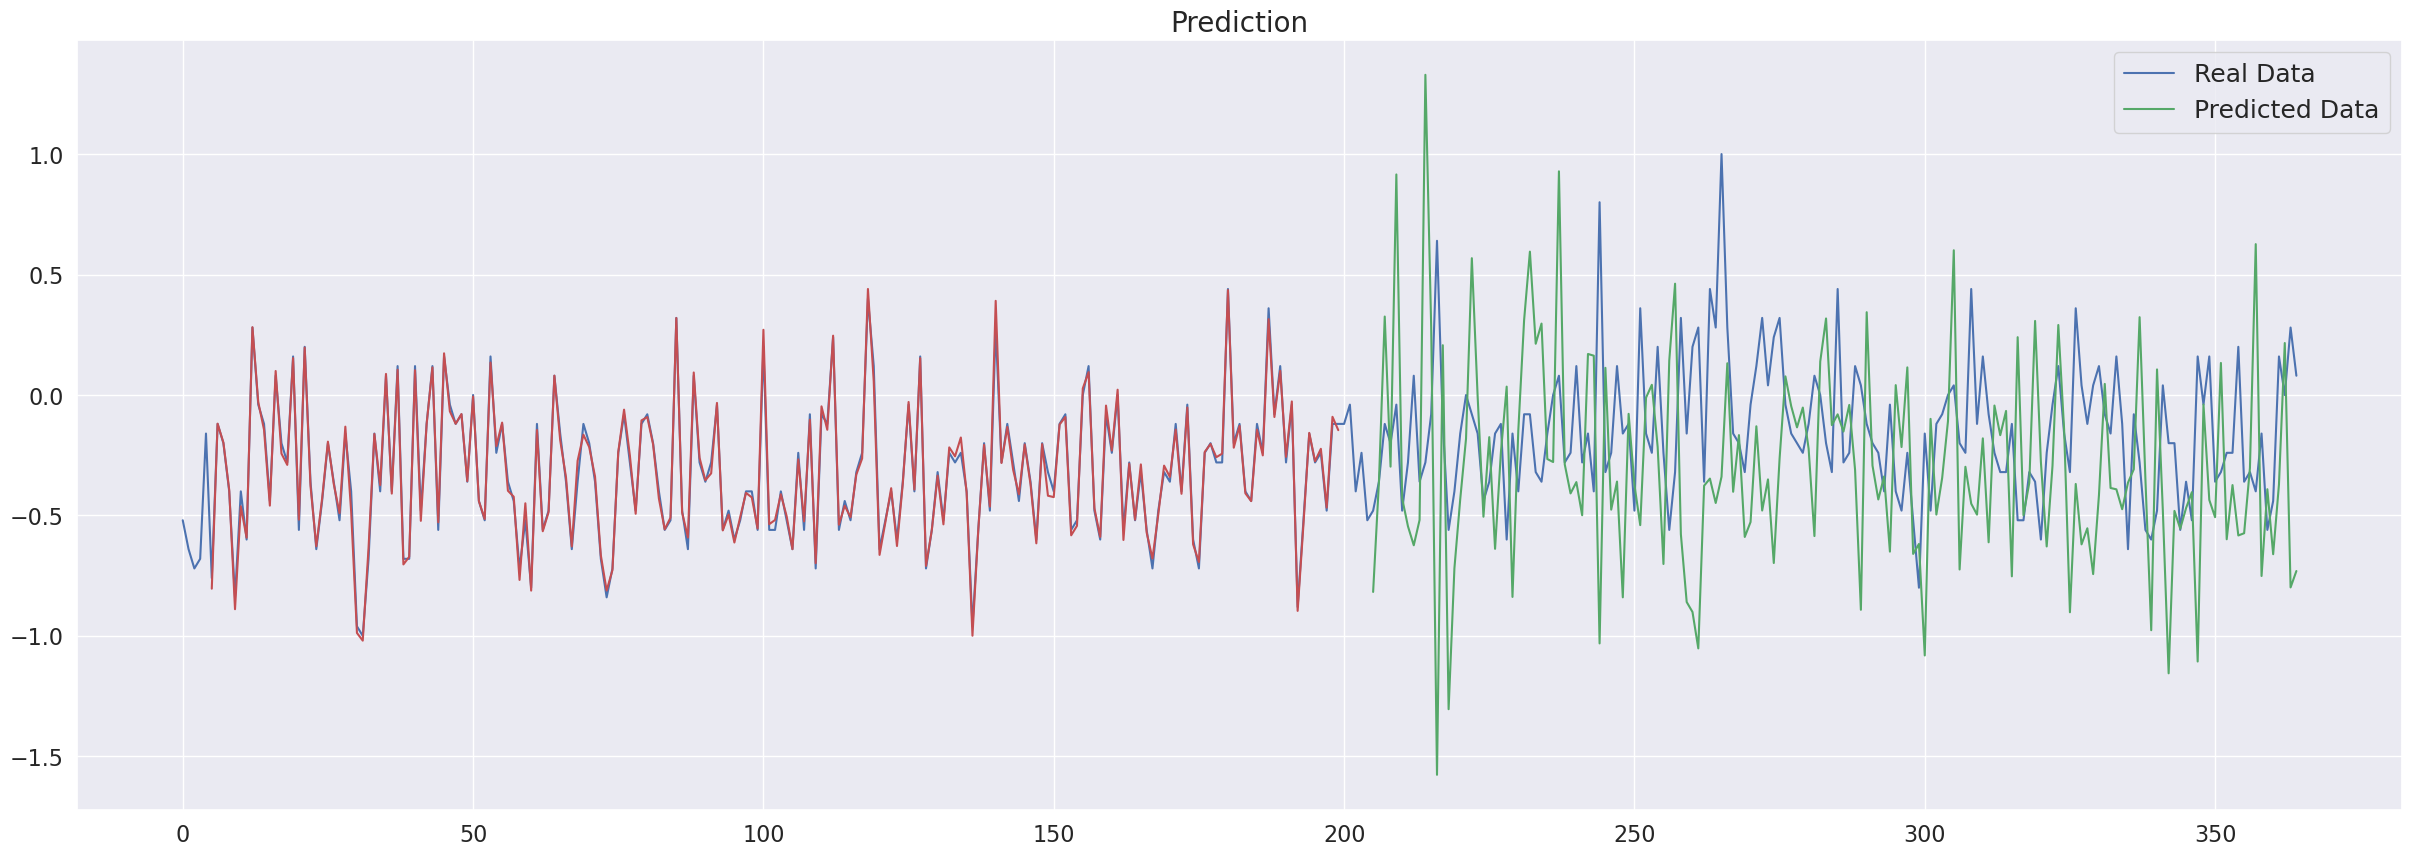

In [58]:
# Plot Prediction
train_size = train_scaled.shape[0]

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(scaled_daily_birth) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(scaled_daily_birth) * np.nan
    test_plot[train_size+lookback:len(scaled_daily_birth)] = model(X_test)[:, -1, :]
# plot
plt.plot(scaled_daily_birth, c='b', label='Real Data')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g', label='Predicted Data')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()

### Anomaly Detection

In [47]:
performance = pd.DataFrame(test_plot, columns=['y_pred']).dropna()
performance = performance.reset_index().drop(columns=['index'])
performance['y_true'] = scaled_daily_birth[-160:]
performance['error'] = performance['y_true'] - performance['y_pred']

In [49]:
window = 7

performance['meanval'] = performance['y_true'].rolling(window=window).mean()
performance['deviation'] = performance['y_true'].rolling(window=window).std()

performance['-3s'] = performance['meanval'] - (2 * performance['deviation'])
performance['3s'] = performance['meanval'] + (2 * performance['deviation'])
performance['-2s'] = performance['meanval'] - (1.75 * performance['deviation'])
performance['2s'] = performance['meanval'] + (1.75 * performance['deviation'])
performance['-1s'] = performance['meanval'] - (1.5 * performance['deviation'])
performance['1s'] = performance['meanval'] + (1.5 * performance['deviation'])

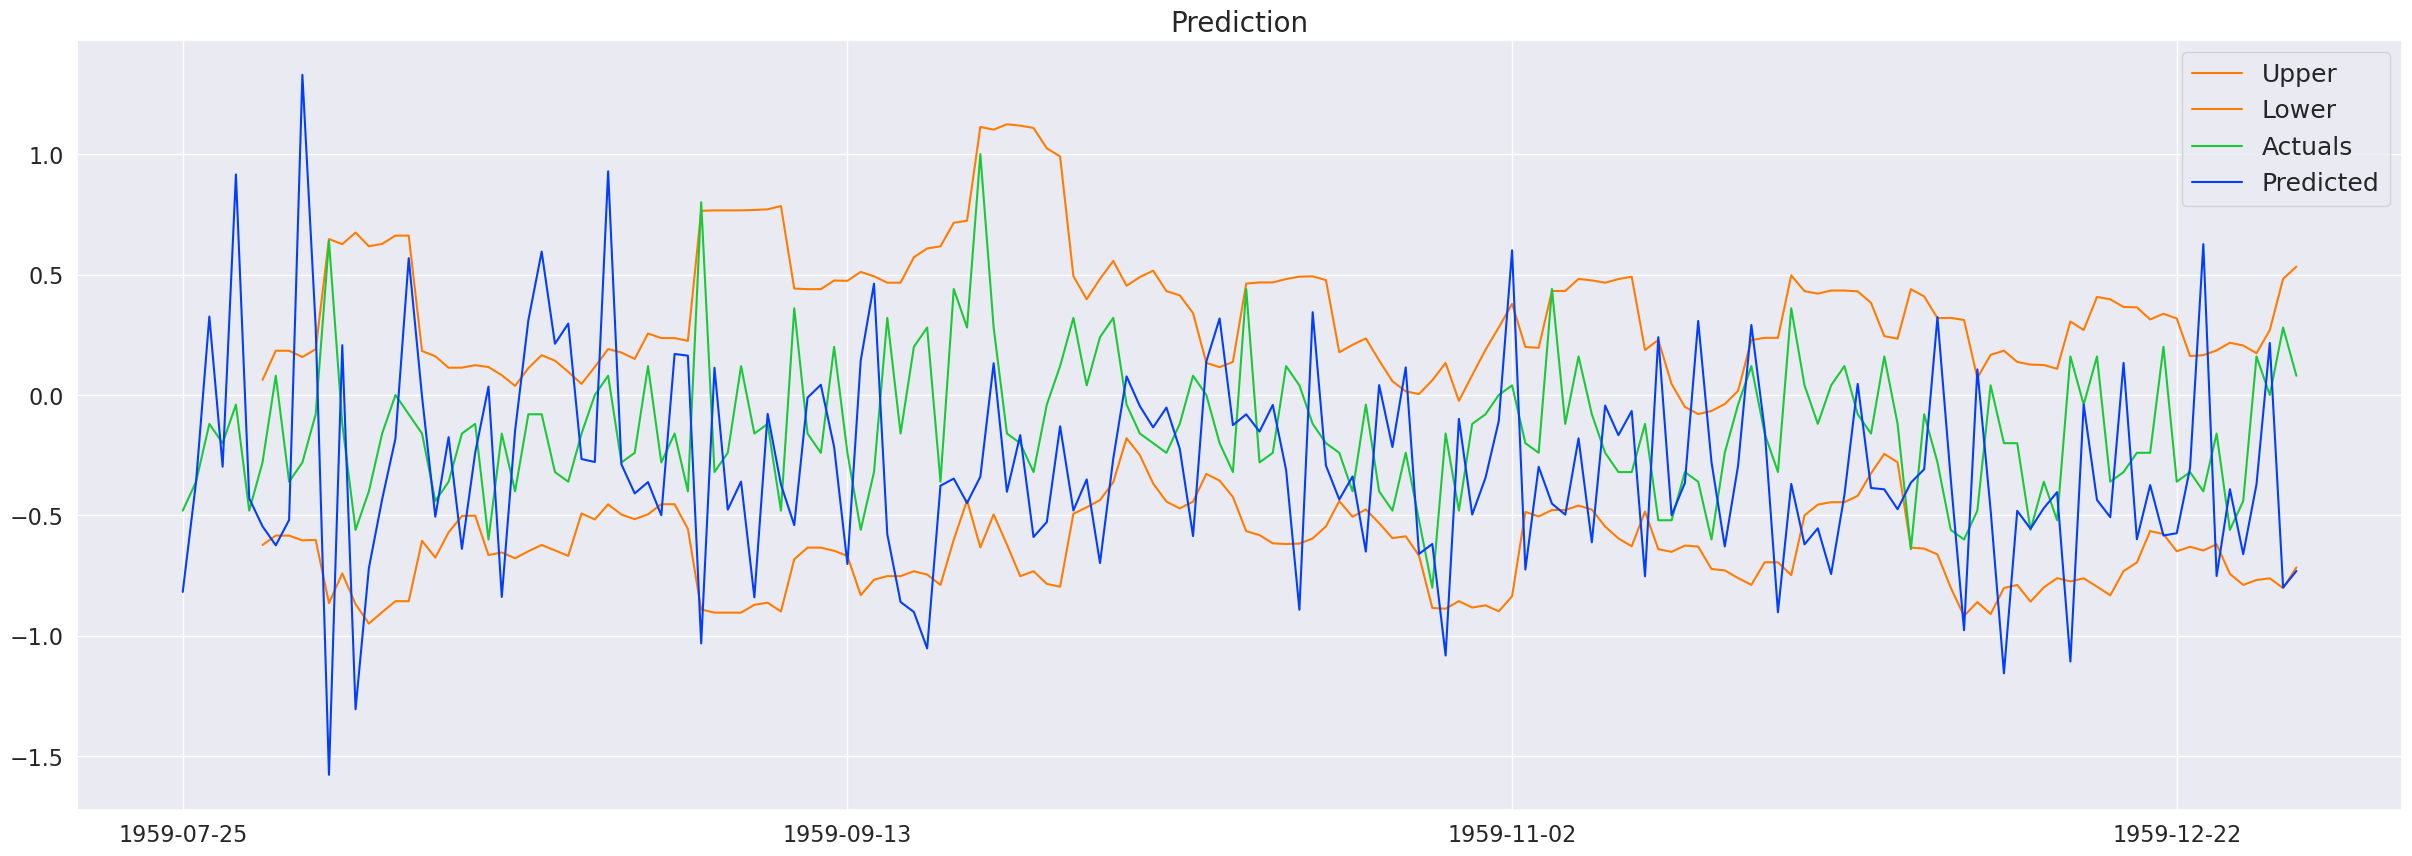

In [87]:
dates = daily_birth_df['Date'][-160:]
dates.index = range(0, 160)
# Upper Bound and Lower Bound
plt.plot(dates, performance['3s'], color=colors[1], label='Upper')
plt.plot(dates, performance['-3s'], color=colors[1], label='Lower')
# Actuals
plt.plot(dates, performance['y_true'], color=colors[2], label='Actuals')
# Predicted
plt.plot(dates, performance['y_pred'], color=colors[0], label='Predicted')
plt.title('Prediction')
plt.legend(loc='upper right')
x_ticks = [k for k in range(0, 160, 50)]
x_labels = dates[range(0, 160, 50)]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.show()

In [88]:
performance['uncertanity'] = performance['3s'] - performance['-3s']
performance['anomaly'] = performance.apply(lambda x: 'Yes' if(np.abs(x['error'] > 1.5*x['uncertanity'])) else 'No', axis=1)
performance['anomaly'].value_counts()

No    160
Name: anomaly, dtype: int64